- https://airflow.apache.org/

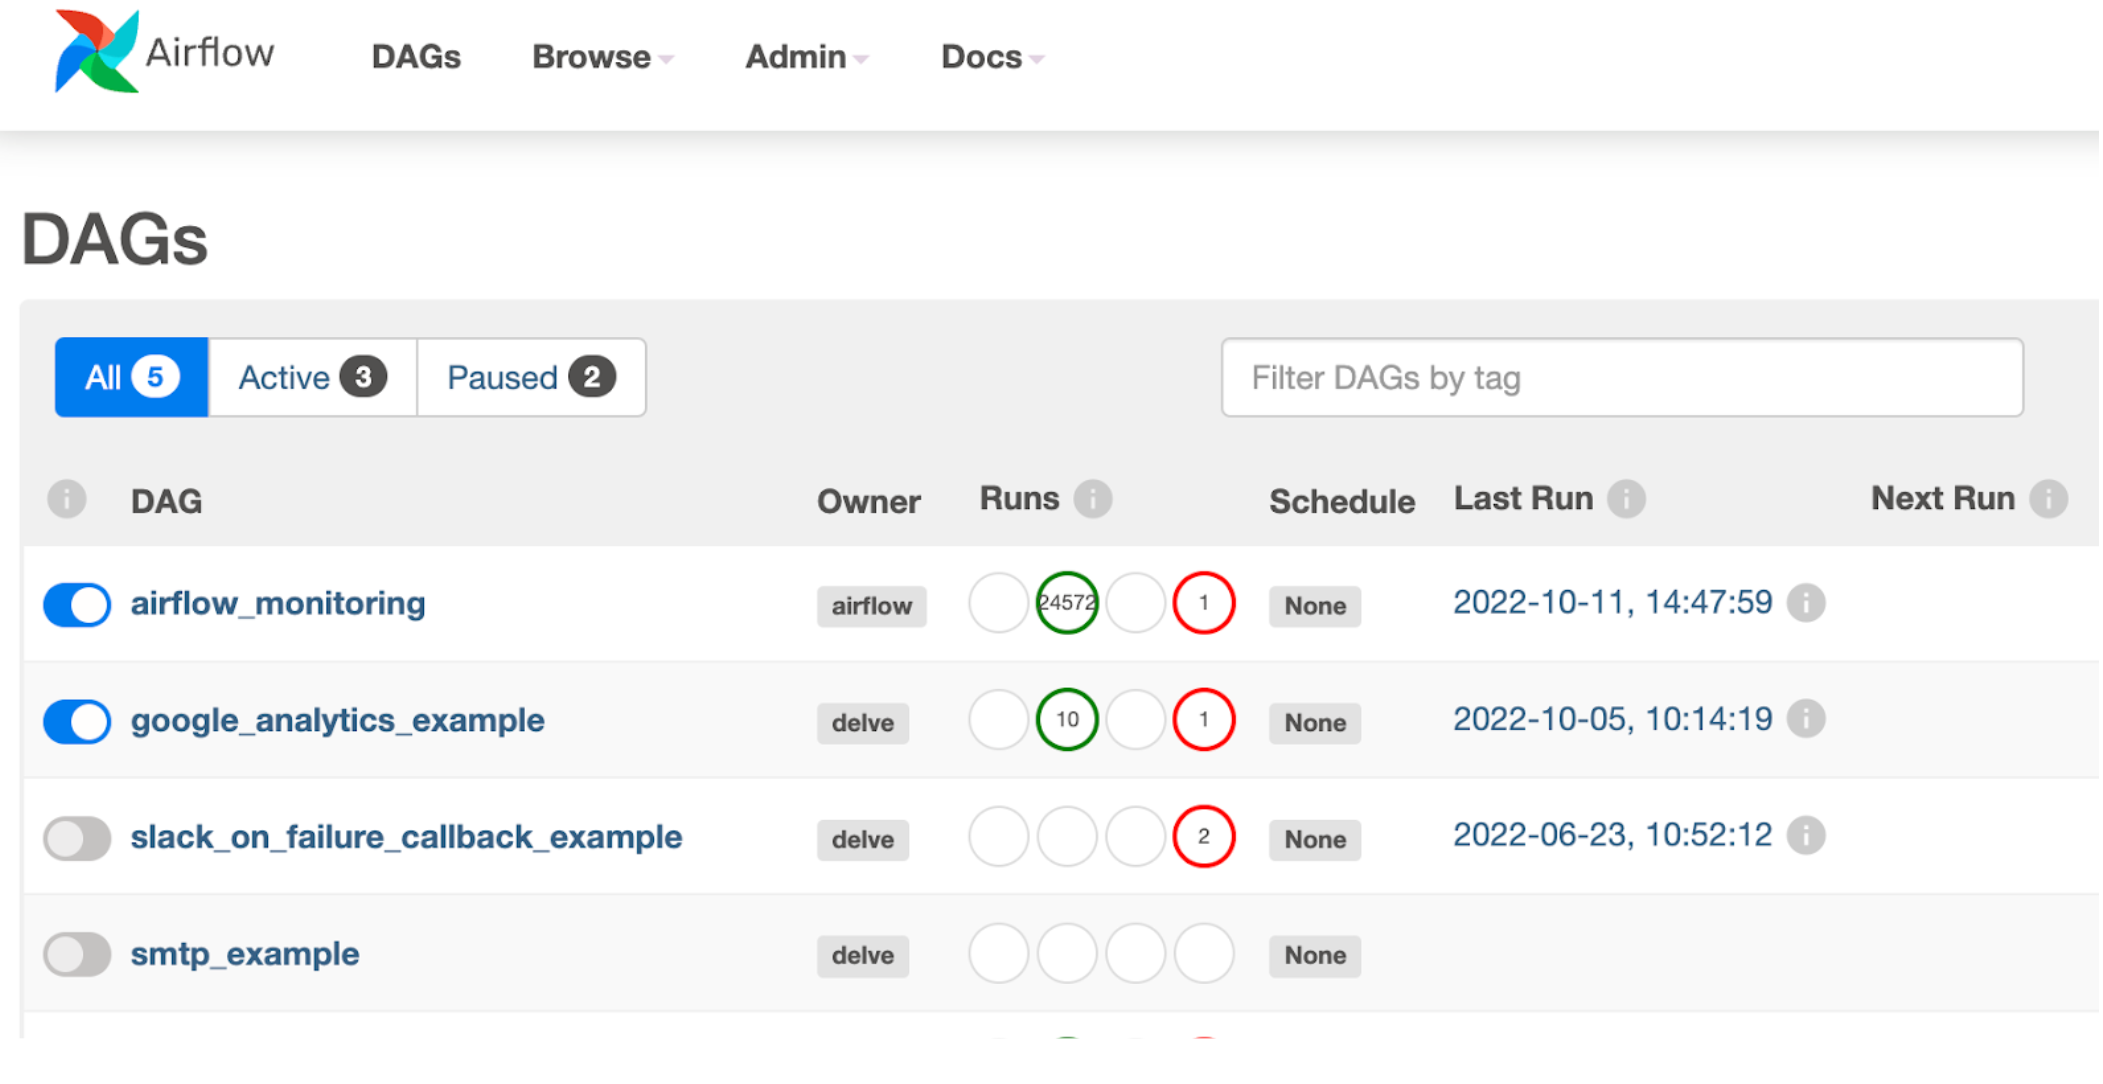

- `composer_dag` (folder) => zawiera plik Python: `google_analytics_example_simple.py` 

- `sessions_user_per_city` => zawiera dane po odpaleniu `google_analytics_example_simple.py` 

Zmienne Airflow:

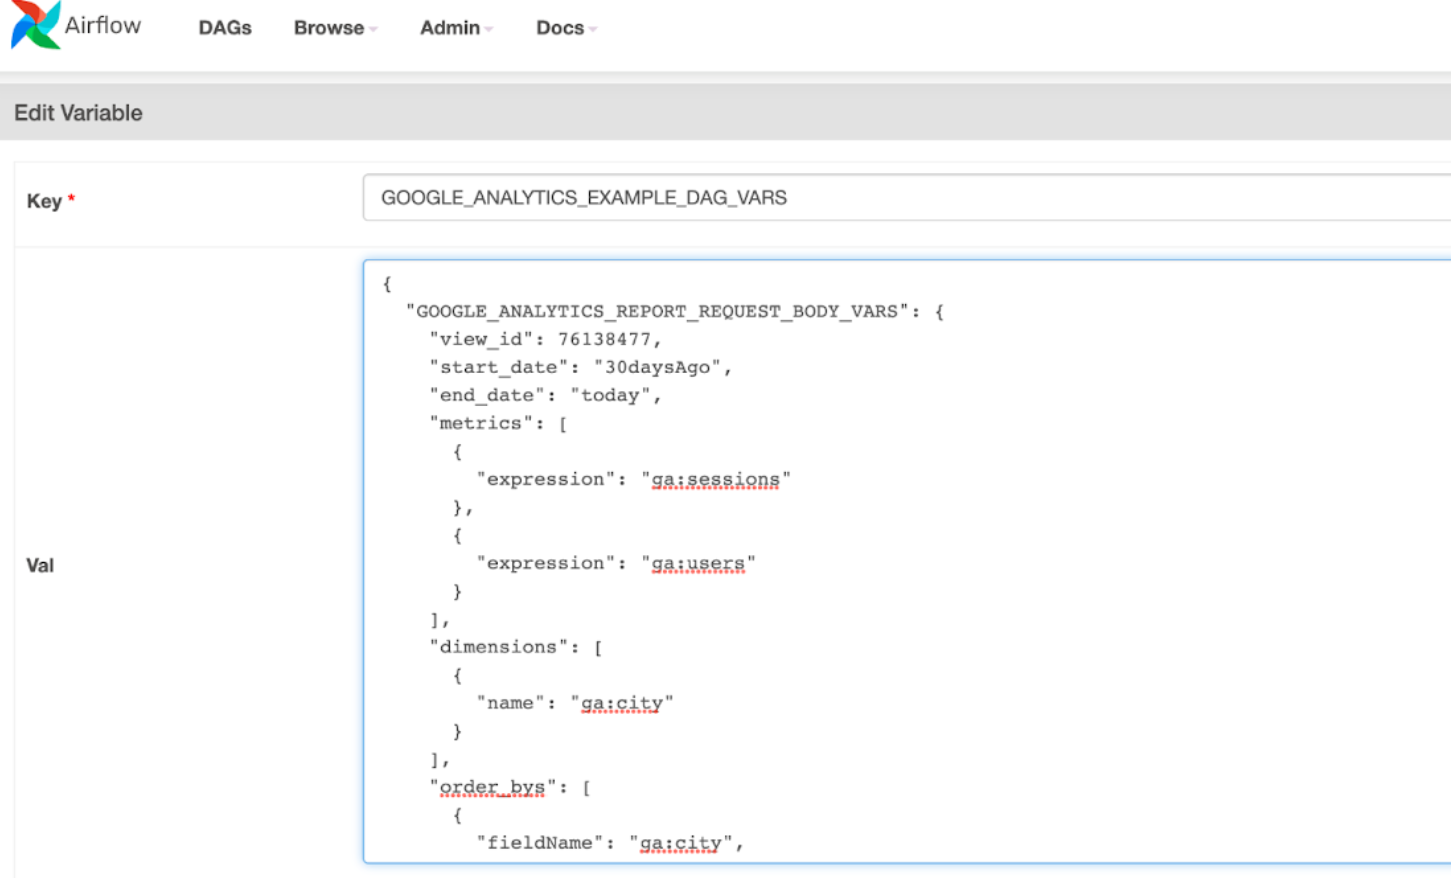

In [ ]:
# DAG import
import os
from datetime import datetime, timedelta
from airflow import DAG

# https://airflow.apache.org/docs/apache-airflow/2.2.5/_api/airflow/operators/dummy/index.html
from airflow.operators.dummy import DummyOperator

from airflow.operators.python import PythonOperator
from airflow.providers.google.cloud.transfers.bigquery_to_gcs import BigQueryToGCSOperator

# Import operatorów niestandardowych
from typing import Any
import pandas_gbq
from airflow.models.baseoperator import BaseOperator
from google import auth
from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build

import logging
import pandas as pd
from inflection import underscore

DAG_ID = os.path.basename(__file__).replace(".pyc", "").replace(".py", "")
START_DATE = datetime(2022, 5, 15)

# Jaka cykliczność odpalania
SCHEDULE_INTERVAL = None

# Kto jest wymieniony jako właściciel tego DAG na serwerze internetowym Airflow?
DAG_OWNER_NAME = "owner_name"

# Lista adresów e-mail, na które będą wysyłane powiadomienia e-mail, jeśli ta praca się nie powiedzie
ALERT_EMAIL_ADDRESSES = ['piotr@google.com']

args = {
    "owner": DAG_OWNER_NAME,
    "depends_on_past": False,
    "email": ALERT_EMAIL_ADDRESSES,
    "start_date": START_DATE,
    "retries": 0,
    "retry_delay": timedelta(minutes=1),
}

# Zmienne Airflow 
airflow_variable = {
            "dimensions": [
                {
                    "name": "ga:city"
                }
            ],
            "metrics": [
                {
                    "expression": "ga:sessions"
                },
                {
                    "expression": "ga:users"
                }
            ],
            "order_bys": [
                {
                    "fieldName": "ga:city",
                    "sortOrder": "DESCENDING"
                }
            ],
}


# Operator niestandardowy
class GoogleAnalyticsReportToBQOperator(BaseOperator):
    
    """
    Operator niestandardowy, który wykonuje wywołania API Google Analytics,
    robi raporty, konwertuje je na df
    i zpaisuje do tabeli BQ.
    """

    ui_color = "#CCCCFF"
    ui_fgcolor = "#000000"

    template_fields = [
        "_report_request_body",
        "_destination_dataset",
        "_destination_table",
        "_if_destination_table_exists",
        "_service_account_info",
        "_service_account_file",
    ]

    def __init__(
        self,
        *,
        report_request_body: dict,
        destination_dataset: str,
        destination_table: str,
        if_destination_table_exists: str,
        service_account_info=None,
        service_account_file: str = None,
        **kwargs,
    ) -> None:


         """
        Argumenty:
            report_request_body: treść żądania raportu zgodna ze specyfikacją API:
                https://developers.google.com/analytics/devguides/reporting/core/v4/rest/v4/reports/batchGet#request-body
            destination_dataset: nazwa docelowego zbioru danych bigquery
            destination_table: nazwa tabeli docelowej bigquery 
            if_destination_table_exists: dyspozycja zapisu dla tabeli bigquery wartości powinny być zgodne
                z parametrem "if_exists" metody to_gbq() z pandas-gbq:
                https://googleapis.dev/python/pandas-gbq/latest/api.html#pandas_gbq.to_gbq
                default value = 'replace'
            service_account_info:
                https://google-auth.readthedocs.io/en/master/reference/google.oauth2.service_account.html#google.oauth2.service_account.IDTokenCredentials.from_service_account_info
            service_account_file:
                https://google-auth.readthedocs.io/en/master/reference/google.oauth2.service_account.html#google.oauth2.service_account.IDTokenCredentials.from_service_account_info
        """


        super().__init__(**kwargs)
        self._report_request_body = report_request_body
        self._destination_dataset = destination_dataset
        self._destination_table = destination_table
        self._if_destination_table_exists = if_destination_table_exists
        self._service_account_info = service_account_info
        self._service_account_file = service_account_file

    def _get_credentials(self):

        """Metoda uzyskiwania poświadczeń używanych w wywołaniach interfejsu API.
            Jeśli oba parametry nie są określone, zwraca domyślne poświadczenia dla konta usługi
            w jakim kontekście wykonywany jest ten kod.
        Zwraca:
            service account poświadczenia:
                https://google-auth.readthedocs.io/en/master/reference/google.oauth2.service_account.html#google.oauth2.service_account.IDTokenCredentials.from_service_account_info
        """

        if self._service_account_info:
            return Credentials.from_service_account_info(self._service_account_info)
        elif self._service_account_file:
            return Credentials.from_service_account_file(self._service_account_file)
        else:
            credentials, project_id = auth.default()
            return credentials

    def _initialize_analytics_reporting(self):

        """Metoda inicjowania obiektu usługi Analytics Reporting API V4.
        Zwraca:
            Autoryzowany obiekt usługi Analytics Reporting API V4.
        """
        credentials = self._get_credentials()

        return build("analyticsreporting", version="v4", credentials=credentials, cache_discovery=False)

    def _get_convert_to_df_write_reports(
        self, analytics, request_body: dict, if_exists: str, loaded_rows: int
    ) -> tuple:

        """Metoda uzyskiwania, konwertowania do df i zapisywania w tabeli BQ danych raportu Google Analytics.
        Args:
            analytics: autoryzowany obiekt usługi Analytics Reporting API V4.
            request_body: powinien zawierać dane w następującej strukturze:
                    https://developers.google.com/analytics/devguides/reporting/core/v4/rest/v4/reports/batchGet?hl=en#request-body
            loaded_rows: liczba wierszy załadowanych do tabeli BigQuery.
        Zwraca:
            Tuple składająca się z listy tokenów następnej strony i liczby stron już załadowanych do tabeli BQ.
        """
        
        report_response = get_report(analytics=analytics, request_body=request_body)
        report_data_frame, next_page_tokens = convert_report_to_data_frame(response=report_response)
        pandas_gbq.to_gbq(
            dataframe=report_data_frame,
            destination_table=f"{self._destination_dataset}.{self._destination_table}",
            if_exists=if_exists,
        )
        loaded_rows += report_data_frame.shape[0]
        return next_page_tokens, loaded_rows

    def execute(self, context: Any) -> int:

        """Rodzaj głównej metody odpowiedzialnej za wywołanie Analytics Reporting API V4
            parsowanie wyników do df i zapisywanie w BigQuery oraz ostatnie, ale nie mniej ważne wywołanie API
            na następnych stronach
        Zwraca:
            liczba wczytanych rekordów
        """

        analytics_client = self._initialize_analytics_reporting()
        next_page_tokens, loaded_rows = self._get_convert_to_df_write_reports(
            analytics=analytics_client,
            request_body=self._report_request_body,
            if_exists=self._if_destination_table_exists,
            loaded_rows=0,
        )
        logging.info(f"Next pages tokens: {next_page_tokens}")

        while next_page_tokens:
            logging.info(
                f"Preparing report request body in order to get next page"
                f" with following tokens:\n{next_page_tokens} "
            )
            requests = self._report_request_body.get("reportRequests", [])
            next_page_requests = []
            for i, report_request in enumerate(requests):
                report_request["pageToken"] = next_page_tokens[i]
                next_page_requests.append(report_request)

            next_report_request_body = {"reportRequests": next_page_requests}
            next_page_tokens, loaded_rows = self._get_convert_to_df_write_reports(
                analytics=analytics_client,
                request_body=next_report_request_body,
                if_exists="append",
                loaded_rows=loaded_rows,
            )

        return loaded_rows


# Custom helpers
def get_google_analytics_report_request_body(
    view_id: int,
    start_date: str,
    end_date: str,
    metrics: list,
    dimensions: list,
    order_bys: list,
    page_size: int,
) -> dict:

    """Funkcja pobierania treści żądania raportu dla interfejsu Analytics Reporting API V4.
    Argumenty:
        view_id: identyfikator widoku Analytics, z którego pobierane są dane.
            Każdy ReportRequest w ramach metody batchGet musi zawierać ten sam viewId.

        start_date: początek zakresu dat.
        
        end_date: koniec zakresu dat.

        metrics: wymagane metryki. Żądania muszą zawierać co najmniej jedną metrykę.
            Żądania mogą mieć łącznie 10 metryk.

        dimensions: wymagane wymiary. Żądania mogą mieć łącznie 9 wymiarów.

        order_bys: porządek sortowania wierszy wyjściowych. Aby porównać dwa wiersze, stosuje się następujące elementy
            w kolejności, aż zostanie znaleziona różnica. Wszystkie zakresy dat w danych wyjściowych otrzymują tę samą kolejność wierszy.

        page_size: rozmiar strony służy do stronicowania i określa maksymalną liczbę zwracanych wierszy.
            Rozmiar strony powinien wynosić >= 0.

    Zwraca:
        Treść żądania raportu dla interfejsu Analytics Reporting API V4.
    """


    return {
        "reportRequests": [
            {
                "viewId": f"{view_id}",
                "dateRanges": [{"startDate": start_date, "endDate": end_date}],
                "metrics": metrics,
                "dimensions": dimensions,
                "orderBys": order_bys,
                "pageSize": page_size,
            }
        ]
    }


def get_report(analytics, request_body: dict) -> dict:

    """Funkcja wysyłania zapytań do interfejsu Analytics Reporting API V4.
    Argumenty:
            analytics: autoryzowany obiekt usługi Analytics Reporting API V4.
            request_body: powinien zawierać dane w następującej strukturze:
                https://developers.google.com/analytics/devguides/reporting/core/v4/rest/v4/reports/batchGet?hl=en#request-body
    Zwraca:
        Odpowiedź interfejsu Analytics Reporting API V4.
    """

    logging.info(f"Getting report data by calling API with following body request:\n{request_body}")
    return analytics.reports().batchGet(body=request_body).execute()


def _get_metric_value_with_type(value: str, metric_type: str):

    """Funkcja zwracająca wartość o odpowiednim typie na podstawie typu danych Analytics Reporting API V4.
        https://developers.google.com/analytics/devguides/reporting/core/v4/rest/v4/reports/batchGet#metrictype
    Argumenty:
        value: wartość metryki jako string
        metric_type: wyliczenia z MetricType
    Zwraca:
        Wartość jako int lub float, jeśli metric_type jest równy „INTEGER” lub „FLOAT”
    """

    if metric_type == "INTEGER":
        return int(value)
    elif metric_type == "FLOAT":
        return float(value)
    else:
        return value


def convert_report_to_data_frame(response: dict) -> tuple:


    """Funkcja, która zwraca odpowiedź raportu jako df
    Argumenty:
        response: wyniki wywołania batchGet z Analytics Reporting API V4.
            https://developers.google.com/analytics/devguides/reporting/core/v4/rest/v4/reports/batchGet
    Zwraca:
        dane df ze znormalizowanymi kolumnami (snake case) i bez przedrostka „ga:”
    """

    report_dimensions = {}
    report_values = {}
    next_page_tokens = []

    for report in response.get("reports", []):
        column_header = report.get("columnHeader", {})
        dimension_headers = column_header.get("dimensions", [])
        metric_headers = column_header.get("metricHeader", {}).get("metricHeaderEntries", [])
        rows = report.get("data", {}).get("rows", [])

        for row in rows:
            dimensions = row.get("dimensions", [])
            date_range_values = row.get("metrics", [])
            for header, dimension in zip(dimension_headers, dimensions):
                if header not in report_dimensions:
                    report_dimensions[header] = []
                report_dimensions[header].append(dimension)

            for values in date_range_values:
                for metric_header, value in zip(metric_headers, values.get("values")):
                    metric_header_name = metric_header.get("name", "unknown")
                    if metric_header_name not in report_values:
                        report_values[metric_header_name] = []
                    report_values[metric_header_name].append(
                        _get_metric_value_with_type(value=value, metric_type=metric_header.get("type", "unknown"))
                    )

        if next_page_token := report.get("nextPageToken", None):
            next_page_tokens.append(next_page_token)

    data_frame = pd.DataFrame()
    for key, value in report_dimensions.items():
        data_frame[underscore(key.replace("ga:", ""))] = value

    for key, value in report_values.items():
        data_frame[underscore(key.replace("ga:", ""))] = value

    return data_frame, next_page_tokens


# zdania DAG
with DAG(
    dag_id=DAG_ID,
    description="Sample DAG which is calling Google Analytics API and save results to BigQuery",
    default_args=args,
    catchup=False,
    schedule_interval=SCHEDULE_INTERVAL,
    render_template_as_native_obj=True,
) as dag:
    start = DummyOperator(task_id="start", dag=dag)

    create_google_analytics_report_request_body = PythonOperator(
        task_id="create_report_request_body",
        python_callable=get_google_analytics_report_request_body,
        op_kwargs={
            "view_id": 76138477,
            "start_date": "30daysAgo",
            "end_date": "today",
            "metrics": airflow_variable['metrics'],
            "dimensions": airflow_variable['dimensions'],
            "order_bys": airflow_variable['order_bys'],
            "page_size": 100
        },
        dag=dag,
    )

    load_google_analytics_to_bigquery = GoogleAnalyticsReportToBQOperator(
        task_id="load_report_to_bq",
        report_request_body='{{ ti.xcom_pull(task_ids="create_report_request_body") }}',
        destination_dataset="google_analytics_dev",
        destination_table="sessions_users_per_city",
        if_destination_table_exists="replace",
        dag=dag,
    )

    export_bq_to_gcs = BigQueryToGCSOperator(
        task_id="export_bq_to_gcs",
        source_project_dataset_table="google_analytics_dev.sessions_users_per_city",
        destination_cloud_storage_uris=["gs://delve-dmt-workshop/sessions_users_per_city.csv"]
    )

    end = DummyOperator(task_id="end", dag=dag)

    start >> create_google_analytics_report_request_body >> load_google_analytics_to_bigquery >> export_bq_to_gcs >> end